# Lab: CNN Tuning and Visualization

## Install and Update Packages

In [2]:
!pip install wandb --upgrade
!pip install grad-cam
!pip install matplotlib --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=2fe40837ca10e2359b269e38a556b43ff9a0df2cf981bccadc3a55d972e47c16
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Un

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/Lab_7/'

Mounted at /content/gdrive


## Import Modules

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from multiprocessing import cpu_count
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import time
import os
import copy
import csv
import wandb
from pytorch_grad_cam import GradCAM

## Basic Configurations

In [3]:
wandb_args = dict(
    api_key = '8c9ae542c28b8a5839444ce0ac22ae9706cc084a',
    entity = 'sawera-yaseen1',  # Your W&B username
    project = 'CNN_models_lab7'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr = 0.001, wt = 1e-6,
    step = 5, gamma = 0.0001,
    epochs = 10,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

wandb: Currently logged in as: sawera-yaseen1. Use `wandb login --relogin` to force relogin


## Preprocess Data

### Fetch the Dataset

In [3]:
!unzip -q "$root_dir""lidar_test_dataset.zip"
data_dir = '/content/dataset/'

mode = 'train'

###Compute Mean and Standard Deviation for Normalization

In [5]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    mean /= samples
    std /= samples
    return mean, std

data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

###Define and Apply Transformations

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

###Split Data into Training and Validation Sets

In [7]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'], (train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

### Sample and Load the Datasets

In [8]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}

## Or Fetch and Preprocess Test Data (to Evaluate Pretrained Models)

In [ ]:
!unzip -q "$root_dir""lidar_test_dataset.zip"
test_data_dir = '/content/test_dataset/'

data_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
test_data = datasets.ImageFolder(test_data_dir, data_transforms)
class_names = test_data.classes

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
mode = 'test'

# Define the Network Architecture
### **Note:** Re-run this code cell each time you want to train the network from scratch!!

In [9]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.num_channels = [1, 6, 12]
        self.w = [100]
        self.h = [100]
        self.padding = 0
        self.dilation = 1
        self.kernel_size = 9
        self.stride = 2

        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, 6, 9, stride=self.stride, padding=self.padding, dilation=self.dilation)),
            ('relu0', nn.ReLU()),
            ('Pool_0', nn.MaxPool2d(2)),
            ('batch_norm0', nn.BatchNorm2d(6)),
            ('conv1', nn.Conv2d(6, 12, 9, stride=self.stride, padding=self.padding, dilation=self.dilation)),
            ('relu1', nn.ReLU()),
            ('Pool_1', nn.MaxPool2d(2)),
            ('batch_norm1', nn.BatchNorm2d(12))
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('fc0', nn.Linear(self.calculate_shape(), 100)),
            ('relu2', nn.ReLU()),
            ('batch_norm2', nn.BatchNorm1d(100)),
            ('fc1', nn.Linear(100, 3)),
            ('softmax', nn.Softmax(dim=1))
        ]))

    def conv_shape(self, H_in, W_in, padding, dilation, kernel_size, stride):
        H_out = math.floor((H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1
        W_out = math.floor((W_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1
        return H_out, W_out

    def pool_shape(self, H_in, W_in, padding, kernel_size, stride):
        H_out = math.floor((H_in + 2 * padding - kernel_size) / stride) + 1
        W_out = math.floor((W_in + 2 * padding - kernel_size) / stride) + 1
        return H_out, W_out

    def calculate_shape(self):
        (H_out, W_out) = self.conv_shape(self.h[0], self.w[0], self.padding, self.dilation, self.kernel_size, self.stride)
        self.h.append(H_out)
        self.w.append(W_out)

        (H_out, W_out) = self.pool_shape(self.h[1], self.w[1], self.padding, 2, 2)
        self.h.append(H_out)
        self.w.append(W_out)

        (H_out, W_out) = self.conv_shape(self.h[2], self.w[2], self.padding, self.dilation, self.kernel_size, self.stride)
        self.h.append(H_out)
        self.w.append(W_out)

        (H_out, W_out) = self.pool_shape(self.h[3], self.w[3], self.padding, 2, 2)
        self.h.append(H_out)
        self.w.append(W_out)

        return self.h[-1] * self.w[-1] * self.num_channels[-1]

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # flatten
        out = self.classifier[0](out)  # Linear layer (fc0)
        out = self.classifier[1](out)  # ReLU layer (relu2)
        out = self.classifier[2](out)  # BatchNorm1d layer (batch_norm2)
        out = self.classifier[3](out)  # Linear layer (fc1)
        out = self.classifier[4](out)  # Softmax layer
        return out

# Instantiate the model
net = LiNet()

# Display the model
print(net)

LiNet(
  (features): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(9, 9), stride=(2, 2))
    (relu0): ReLU()
    (Pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_norm0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(6, 12, kernel_size=(9, 9), stride=(2, 2))
    (relu1): ReLU()
    (Pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_norm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=192, out_features=100, bias=True)
    (relu2): ReLU()
    (batch_norm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
  )
)


## Check if everything works correctly

In [10]:
# Create a dummy tensor of size (B x C x H x W) and pass it through the network
dummy_input = torch.randn(2, 1, 100, 100)
output = net(dummy_input)

# Print the shape of the output and verify if it is as expected
print ("Output shape", output.shape)

Output shape torch.Size([2, 3])


##And (optionally) load a pretrained model

In [ ]:
state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
net.load_state_dict(state_dict)
net.eval()

LiNet(
  (features): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
    (relu0): ReLU()
    (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(6, 12, kernel_size=(9, 9), stride=(1, 1))
    (relu1): ReLU()
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=4332, out_features=100, bias=True)
    (relu): ReLU()
    (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
    (fc2): Linear(in_features=3, out_features=3, bias=True)
  )
)

# Determine the number of Parameters

In [11]:
param_count = sum(p.numel() for p in net.parameters()) / 1000000
print('\nTotal Parameter Count: %.7f M' % param_count)


Total Parameter Count: 0.0261750 M


### Can you determine the number of parametres in the feature extractor?

In [12]:
# Count the number of parameters in the feature extractor
feature_params_count = sum(p.numel() for p in net.features.parameters()) /1000000

# # Print the result
print('\nNumber of Parameters in Feature Extractor: %.7f M' % feature_params_count)


Number of Parameters in Feature Extractor: 0.0063720 M


#Train and Validate

### **Note**: Re-run the code cell that defines the network architecture before starting a new run!!

Saving checkpoints in: /content/gdrive/My Drive/Lab_7/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab_7/logs/LiNet/LiNet-cnn-log.txt

Epoch 1/10
----------
Train Loss: 0.6553 Acc: 0.9010
Val Loss: 0.6483 Acc: 0.9024

Epoch 2/10
----------
Train Loss: 0.6049 Acc: 0.9485
Val Loss: 0.6537 Acc: 0.8956

Epoch 3/10
----------
Train Loss: 0.5946 Acc: 0.9582
Val Loss: 0.6362 Acc: 0.9131

Epoch 4/10
----------
Train Loss: 0.5863 Acc: 0.9661
Val Loss: 0.6269 Acc: 0.9240

Epoch 5/10
----------
Train Loss: 0.5832 Acc: 0.9693
Val Loss: 0.6304 Acc: 0.9204

Epoch 6/10
----------
Train Loss: 0.5781 Acc: 0.9745
Val Loss: 0.6292 Acc: 0.9203

Epoch 7/10
----------
Train Loss: 0.5781 Acc: 0.9745
Val Loss: 0.6236 Acc: 0.9259

Epoch 8/10
----------
Train Loss: 0.5786 Acc: 0.9738
Val Loss: 0.6249 Acc: 0.9239

Epoch 9/10
----------
Train Loss: 0.5786 Acc: 0.9740
Val Loss: 0.6274 Acc: 0.9221

Epoch 10/10
----------
Train Loss: 0.5775 Acc: 0.9750
Val Loss: 0.6276 Acc: 0.9212

Training complete in 14

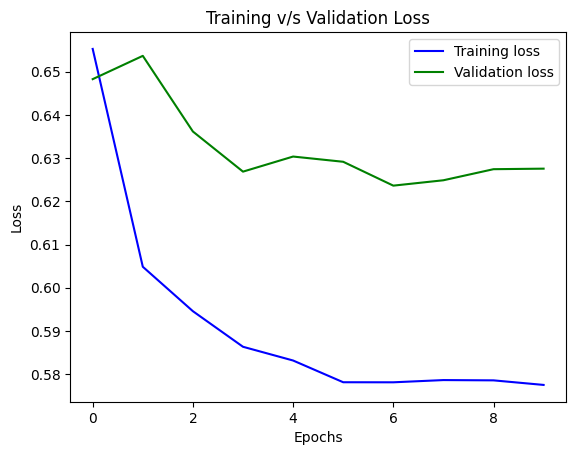

train_acc,▁▅▆▇▇█████
train_loss,█▃▃▂▂▁▁▁▁▁
val_acc,▃▁▅█▇▇██▇▇
val_loss,▇█▄▂▃▂▁▁▂▂
train_acc,0.975
train_loss,0.57751
val_acc,0.92124
val_loss,0.62757


In [13]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-cnn-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

# Evaluate the Model

In [14]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-xxx-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 92.9705%
	Accuracy of corridor : 94.2977%
	Accuracy of door : 86.3720%
	Accuracy of room : 98.4576%

Kappa Score: 0.8946

               precision    recall  f1-score   support

    corridor       0.92      0.94      0.93      1666
        door       0.94      0.86      0.90      1629
        room       0.93      0.98      0.95      1556

    accuracy                           0.93      4851
   macro avg       0.93      0.93      0.93      4851
weighted avg       0.93      0.93      0.93      4851



# Estimate the Inference Speed

In [15]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.8f s' % inference_speed)
    print('Throughput: %d images' % throughput)

get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.00001077 s
Throughput: 92871 images


# Make Predictions

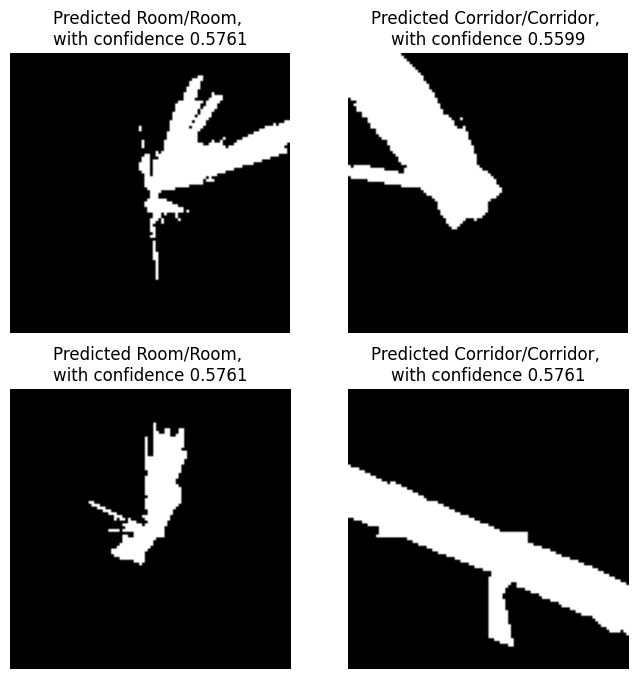

In [16]:
def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Filters (Features) and Activations (Feature Maps)

In [17]:
def get_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)):
            conv_layers.append(module)
        elif type(module)==nn.Sequential:
            conv_layers.extend(get_convs(module.children()))
    return conv_layers

convs = get_convs(net.features)
for conv in convs:
    print(f'CONV: {conv} => SHAPE: {conv.weight.shape}')

CONV: Conv2d(1, 6, kernel_size=(9, 9), stride=(2, 2)) => SHAPE: torch.Size([6, 1, 9, 9])
CONV: Conv2d(6, 12, kernel_size=(9, 9), stride=(2, 2)) => SHAPE: torch.Size([12, 6, 9, 9])


In [ ]:
def visualize_filters(convs):
    for conv in convs:
        in_ch, out_ch = conv.in_channels, conv.out_channels
        fig = plt.figure(figsize=(out_ch*2, in_ch*2), constrained_layout=True)
        fig.suptitle(f'CONV: {conv}', size=16)
        for i in range(in_ch):
            for j in range(out_ch):
                idx = (i*out_ch)+(j+1)
                ax = plt.subplot(in_ch, out_ch, idx)
                ax.axis('off')
                ax.imshow(conv.weight[j][i].detach(), cmap='gray')
                # Dim --> Out Ch x In Ch x K x K


visualize_filters(convs)

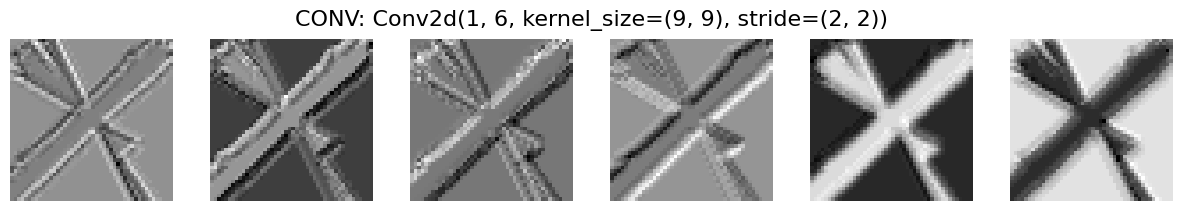

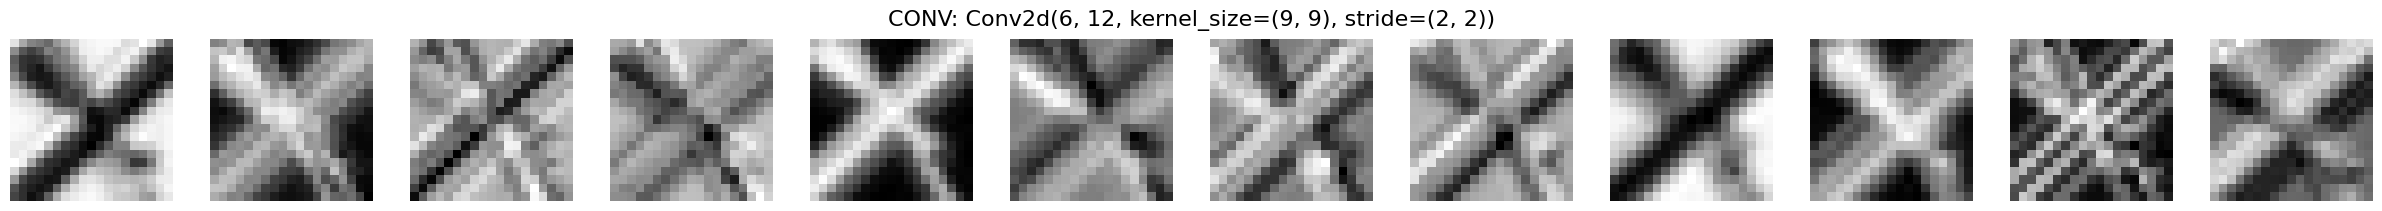

In [18]:
def visualize_activations(convs, dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x H x W
        img = inputs[:1]

        activations = [convs[0](img)]
        for i in range(1, len(convs)):
            activations.append(convs[i](activations[-1]))

        for conv, act in zip(convs, activations):
            out_ch = conv.out_channels
            fig = plt.figure(figsize=(out_ch*2, 2), constrained_layout=True)
            fig.suptitle(f'CONV: {conv}', size=16)
            for j in range(out_ch):
                ax = plt.subplot(1, out_ch, j+1)
                ax.axis('off')
                ax.imshow(act.detach().squeeze()[j].cpu(), cmap='gray')
                # Dim --> B x Out Ch x H' x W'
        return


visualize_activations(convs, dataloaders['test'] if mode=='train' else test_dataloader)

# Visualize Grad-CAMs

<ipython-input-19-67b55e03e415>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


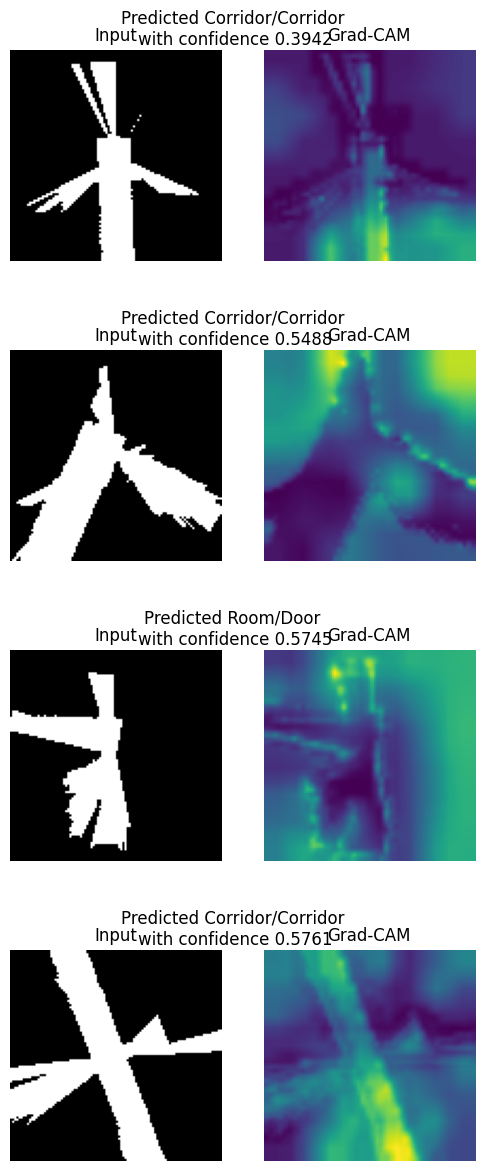

In [19]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    cam = GradCAM(model=model, target_layers=model.features, use_cuda=False)

    fig = plt.figure(constrained_layout=True, figsize=(6,12))
    fig.tight_layout()
    subfigs = fig.subfigures(nrows=num_images, ncols=1)

    for inputs, labels in dataloader:
        inputs = inputs.to(device)                      # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)                         # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1,True)                   # B x classes

        masks = cam(input_tensor=inputs[:num_images])

        for j in range(inputs.size()[0]):
            axs = subfigs[j].subplots(1, 2)
            subfigs[j].suptitle('Predicted {1}/{2} \nwith confidence {0:.4f}'.format(prob[j][0],
                class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
            axs[0].axis('off')
            axs[0].set_title('Input')
            axs[0].imshow(inputs[j].cpu().squeeze(), cmap='gray')
            axs[1].axis('off')
            axs[1].set_title('Grad-CAM')
            axs[1].imshow(masks[j])

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)


visualize(net, dataloaders['test'] if mode=='train' else test_dataloader)

#Save the Trained Model

In [20]:
torch.save(net.state_dict(),root_dir+'cnn_classification.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

# **Depth_Wise Separable CNN Model**

**Define the Network Architecture**

In [9]:
class DepthwiseSeparableNet(nn.Module):
  def __init__(self, num_classes = 3):
    super(DepthwiseSeparableNet, self).__init__()
    self.features = nn.Sequential(OrderedDict([
        ('depthwise0', nn.Conv2d(1, 1, kernel_size = 9, groups =1)),  # Depth-wise convolution
        ('pointwise0', nn.Conv2d(1,6,kernel_size=1)),  # Point-wise convolution
        ('relu0', nn.ReLU()),
        ('pool0', nn.MaxPool2d(kernel_size=2, stride = 2)),
        ('batchnorm0', nn.BatchNorm2d(6)),

        ('depthwise1', nn.Conv2d(6, 6, kernel_size = 9, groups =6)),  # Depth-wise convolution
        ('pointwise1', nn.Conv2d(6,12,kernel_size=1)),  # Point-wise convolution
        ('relu1', nn.ReLU()),
        ('pool1', nn.MaxPool2d(kernel_size=2, stride = 2)),
        ('batchnorm1', nn.BatchNorm2d(12))
    ]))

    input_size = (1,100,100)
    with torch.no_grad():
      features_output = self.features(torch.zeros(1, *input_size))
      features_output_size = features_output.view(features_output.size(0), -1).size(1)

    self.classifier = nn.Sequential(OrderedDict([
      ('fc0', nn.Linear(features_output_size, 100)),
      ('relu', nn.ReLU()),
      ('batchnorm2', nn.BatchNorm1d(100)),
      ('fc1', nn.Linear(100, num_classes)),
      ('softmax', nn.Softmax(dim=1)),
      ('fc2', nn.Linear(num_classes, num_classes))
    ]))


  def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

# Instantiate the model
model = DepthwiseSeparableNet()

# Display the model
print(model)


DepthwiseSeparableNet(
  (features): Sequential(
    (depthwise0): Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1))
    (pointwise0): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
    (relu0): ReLU()
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise1): Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1), groups=6)
    (pointwise1): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (fc0): Linear(in_features=4332, out_features=100, bias=True)
    (relu): ReLU()
    (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=100, out_features=3,

**Check if Everything works correctly**

In [10]:
# Create a dummy tensor of size (B x C x H x W) and pass it through the network
dummy_input = torch.randn(2, 1, 100, 100)
output = model(dummy_input)

# Print the shape of the output and verify if it is as expected
print ("Output shape", output.shape)

Output shape torch.Size([2, 3])


**Determine Number of Parameters**

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of parameters
num_params = count_parameters(model)
print(f"Number of parameters: {num_params}")


Number of parameters: 434521


In [12]:
# Count the number of parameters in the feature extractor
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the number of parameters in the feature extractor
feature_extractor_params = count_parameters(model.features)
print(f"Number of parameters in the feature extractor: {feature_extractor_params}")


Number of parameters in the feature extractor: 706


**Basic Configurations**

In [4]:
wandb_args = dict(
    api_key = '8c9ae542c28b8a5839444ce0ac22ae9706cc084a',
    entity = 'sawera-yaseen1',  # Your W&B username
    project = 'CNN_models_lab7'
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr = 0.001, wt = 1e-6,
    step = 5, gamma = 0.0001,
    epochs = 10,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

wandb: Currently logged in as: sawera-yaseen1. Use `wandb login --relogin` to force relogin


**Train & Validate**

Saving checkpoints in: /content/gdrive/My Drive/Lab_7/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/Lab_7/logs/LiNet/LiNet-depth-log.txt

Epoch 1/10
----------
Train Loss: 0.6502 Acc: 0.9023
Val Loss: 0.5076 Acc: 0.8732

Epoch 2/10
----------
Train Loss: 0.2772 Acc: 0.9625
Val Loss: 0.4577 Acc: 0.8557

Epoch 3/10
----------
Train Loss: 0.1561 Acc: 0.9757
Val Loss: 0.2737 Acc: 0.9215

Epoch 4/10
----------
Train Loss: 0.1016 Acc: 0.9833
Val Loss: 0.2500 Acc: 0.9309

Epoch 5/10
----------
Train Loss: 0.0748 Acc: 0.9867
Val Loss: 0.2715 Acc: 0.9241

Epoch 6/10
----------
Train Loss: 0.0632 Acc: 0.9888
Val Loss: 0.2662 Acc: 0.9282

Epoch 7/10
----------
Train Loss: 0.0652 Acc: 0.9881
Val Loss: 0.2608 Acc: 0.9310

Epoch 8/10
----------
Train Loss: 0.0643 Acc: 0.9885
Val Loss: 0.2632 Acc: 0.9293

Epoch 9/10
----------
Train Loss: 0.0674 Acc: 0.9878
Val Loss: 0.2659 Acc: 0.9278

Early stopping! Completed in 173m 52s
Best val Acc: 0.930902



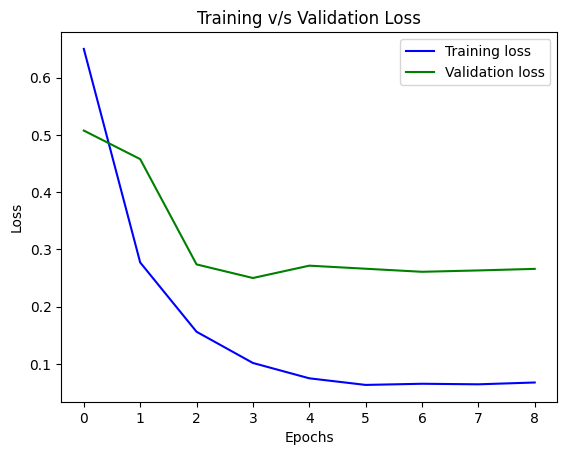

train_acc,▁▆▇██████
train_loss,█▄▂▁▁▁▁▁▁
val_acc,▃▁▇█▇████
val_loss,█▇▂▁▂▁▁▁▁
train_acc,0.98777
train_loss,0.06744
val_acc,0.92777
val_loss,0.26595


In [17]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25,
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-depth-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images

            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)
            wandb_logger.log({
                phase+'_loss': epoch_loss,
                phase+'_acc': epoch_acc,
            }, step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                best_acc = epoch_acc
            elif phase == 'val' and epoch_loss >= min_loss:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)

        # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])

net = model.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=config['epochs'],
                           logging=True, checkpointing=True)

plot_loss(*history)
wandb_logger.finish()

**Evalute the Model**

In [18]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-depth-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'] if mode=='train' else test_dataloader, out_file_path)

Accuracy of the network on 4851 test images: 95.1556%
	Accuracy of corridor : 97.0767%
	Accuracy of door : 89.5172%
	Accuracy of room : 98.6544%

Kappa Score: 0.9273

               precision    recall  f1-score   support

    corridor       0.95      0.97      0.96      1642
        door       0.96      0.90      0.93      1574
        room       0.94      0.99      0.97      1635

    accuracy                           0.95      4851
   macro avg       0.95      0.95      0.95      4851
weighted avg       0.95      0.95      0.95      4851



**Estimate the Inference Speed**

In [19]:
def get_fps(model, dataloader, reps=10):
    model.to(device)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]

            # GPU warmup
            if device == 'cuda':
                for _ in range(10):
                    _ = model(inputs)
                torch.cuda.synchronize()

            start = time.time()
            for i in range(reps):
                _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            elapsed_time = (end-start)
            inference_speed = elapsed_time / (reps * batch_size)
            throughput = (reps * batch_size) / elapsed_time
            break
    print('Inference speed: %.8f s' % inference_speed)
    print('Throughput: %d images' % throughput)

get_fps(net, dataloaders['test'] if mode=='train' else test_dataloader)

Inference speed: 0.00297675 s
Throughput: 335 images


**Make Predictions**

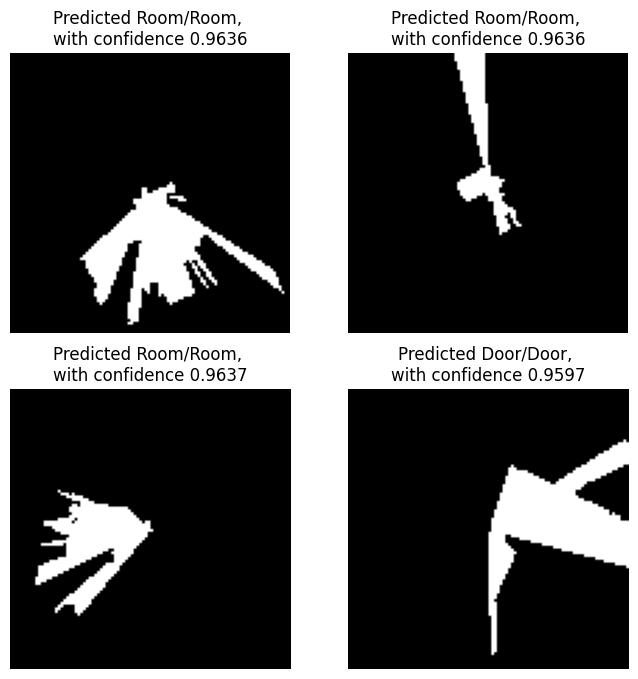

In [20]:
def predict(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(8,8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)                      # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)                         # batch x classes
            prob = nn.functional.softmax(outputs, dim=-1)
            prob, idx = prob.sort(1,True)                   # batch x classes

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2}, \nwith confidence {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                ax.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net, dataloaders['test'] if mode=='train' else test_dataloader)

**Visualize Filters (Features) and Activations (Feature Maps)**

In [21]:
def get_depthwise_separable_convs(layers):
    conv_layers = []
    for module in layers:
        if 'Conv2d' in str(type(module)) and module.groups == module.in_channels:
            conv_layers.append(module)
        elif type(module) == nn.Sequential:
            conv_layers.extend(get_depthwise_separable_convs(module.children()))
    return conv_layers


# Get depthwise separable convolutional layers and print their information
depthwise_separable_convs = get_depthwise_separable_convs(net.features)
for i, conv in enumerate(depthwise_separable_convs, 1):
    print(f'Depthwise Separable CONV-{i}: {conv} => SHAPE: {conv.weight.shape}')



Depthwise Separable CONV-1: Conv2d(1, 1, kernel_size=(9, 9), stride=(1, 1)) => SHAPE: torch.Size([1, 1, 9, 9])
Depthwise Separable CONV-2: Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1)) => SHAPE: torch.Size([6, 1, 1, 1])
Depthwise Separable CONV-3: Conv2d(6, 6, kernel_size=(9, 9), stride=(1, 1), groups=6) => SHAPE: torch.Size([6, 1, 9, 9])


**Visualize Grad-CAMs**

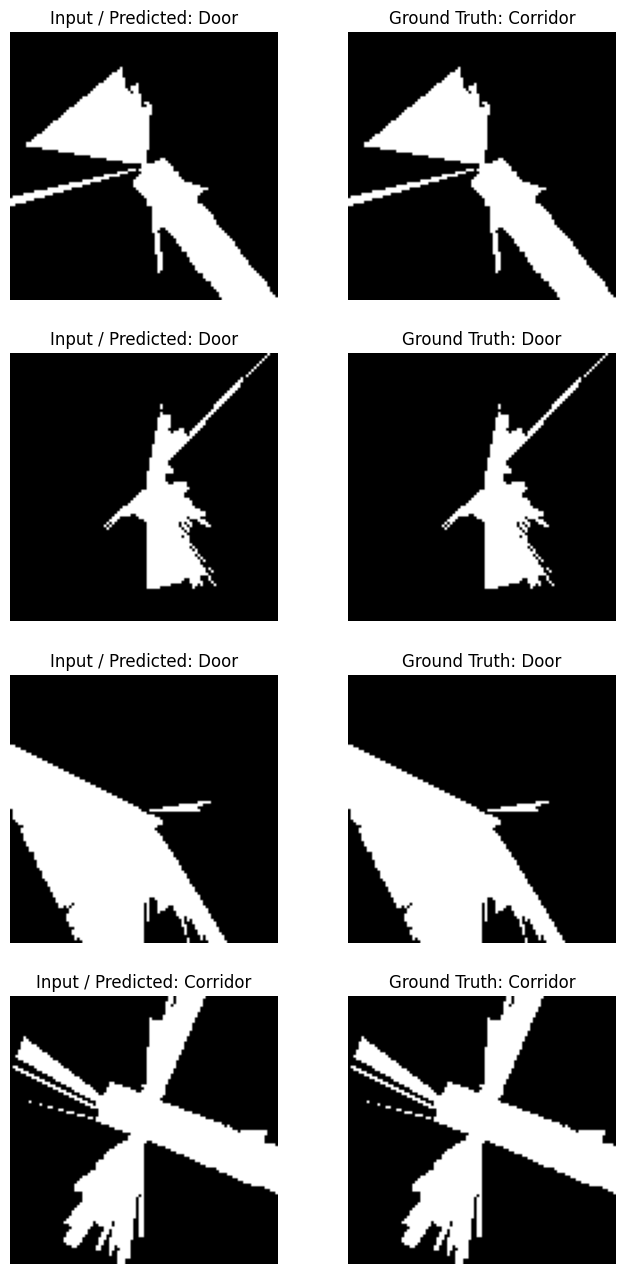

In [26]:
def visualize(model, dataloader, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0

    fig, axs = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # B x C x W x H
        labels = labels.to(device)

        outputs = model(inputs)  # B x classes
        prob = nn.functional.softmax(outputs, dim=-1)
        prob, idx = prob.sort(1, True)  # B x classes

        for j in range(inputs.size()[0]):
            axs[j, 0].axis('off')
            axs[j, 0].set_title('Input / Predicted: {}'.format(class_names[idx[j][0]].capitalize()))
            axs[j, 0].imshow(inputs[j].cpu().squeeze(), cmap='gray')

            axs[j, 1].axis('off')
            axs[j, 1].set_title('Ground Truth: {}'.format(class_names[labels[j]].capitalize()))
            axs[j, 1].imshow(inputs[j].cpu().squeeze(), cmap='gray')

            images_so_far += 1
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)

# Call the function with your depthwise separable CNN
visualize(net, dataloaders['test'] if mode == 'train' else test_dataloader)


**Save the Trained Model**

In [27]:
torch.save(net.state_dict(),root_dir+'depth_wise_cnn_claasification.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()

# **Questions**

1. Yes, There is a positive impact on the model's performance when accounting for the class imbalance. because when the data is imbalanced, what happens during training is that the model will behave biased towards the majority class here in our case it was biased towards the **Room** class and performed badly on the minority class in our case **Door** class. and since we have an imbalanced dataset with having majority of data for room class and less data for door, accounting for the class imbalance will result in a highly robust model with improved performance. Also, the model will be able to generalize for every class on data.

2. Increasing the receptive field using dilated convolutions or stacked convolutions may have a significant positive impact on the model's performance, but we'll also have to consider the risk of overfitting/underfitting as well as the computational constraints. For this particular task (Classification of Door, Corridor, or Room) since this dataset is an indoor scenes dataset it was better to increase the receptive field because in this way model was able to capture wider context information.

3. The model is sometimes making mistakes in the prediction of the door class, It is predicting the room or corridor classes in place of the door class, this might be because there are quite similar features of a door and room. The other thing is there is very little training data for the door class. These ambiguities can be removed by fine-tuning the model as well as by increasing the data for door class by using the data augmentation technique.